In [14]:
!pip install catboost
!pip install tqdm_joblib
!pip install optuna

In [15]:
!python --version

Python 3.11.13


In [16]:
!pip freeze

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.16.4
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.7.14.0.40.29
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.10.0
bigquery-magics==0.10.1
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
catboost==1.2.8
certifi==2025.7.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpi

In [17]:
# # train_model.py
# # final with GPU acceleration, progress tracking, and warnings suppressed

# import os
# import warnings
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

# import pandas as pd
# import numpy as np
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import StackingRegressor
# from sklearn.model_selection import TimeSeriesSplit, cross_validate
# from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
# from scipy.stats import zscore
# import joblib

# # Progress tracking
# from tqdm.auto import tqdm
# from tqdm_joblib import tqdm_joblib

# # Detect GPU usage via environment variable
# # Automatically detect GPU presence (e.g., in Colab)
# def detect_gpu():
#     try:
#         import subprocess
#         subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
#         return True
#     except Exception:
#         return False

# USE_GPU = detect_gpu()
# print(f"GPU detected: {USE_GPU}")
# # 1) Custom transformer: date + engineered + time features
# class FeatureTransformer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         dates = pd.to_datetime(X['Date Sold'], dayfirst=True)
#         X['day'] = dates.dt.day
#         X['month'] = dates.dt.month
#         X['year'] = dates.dt.year
#         X['age'] = X['year'] - X['Year Built']
#         start = dates.min()
#         X['days_since_start'] = (dates - start).dt.days
#         X['time_sq'] = X['days_since_start'] ** 2
#         X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
#         X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
#         return X.drop(columns=['Date Sold'])


# def main():
#     # Load and clean data
#     # df = pd.read_excel("./Case Study 1 Data.xlsx")
#     df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")
#     df = df.drop(columns=['Property ID']).dropna(subset=['Price'])
#     df['price_z'] = zscore(df['Price'])
#     df = df[df['price_z'].abs() <= 3].drop(columns=['price_z'])
#     X = df.drop(columns=['Price'])
#     y = df['Price']

#     # Preprocessing setup
#     numeric_feats = [
#         'Size', 'Bedrooms', 'Bathrooms', 'Year Built',
#         'day', 'month', 'year', 'age','days_since_start', 'time_sq', 'month_sin',
#         'month_cos' ]
#     cat_feats = ['Location', 'Condition', 'Type']

#     num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
#     cat_pipe = Pipeline([
#         ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
#     ])
#     preprocessor = ColumnTransformer([
#         ('num', num_pipe, numeric_feats),
#         ('cat', cat_pipe, cat_feats)
#     ], remainder='drop')

#     # Define model parameters
#     lgbm_params = {
#         'random_state': 24,
#         'n_jobs': -1,
#         'n_estimators': 200,
#     }
#     xgb_params = {
#         'random_state': 24,
#         'use_label_encoder': False,
#         'eval_metric': 'rmse',
#         'n_jobs': -1,
#         'n_estimators': 200,
#     }
#     cat_params = {
#         'random_state': 24,
#         'iterations': 200,
#         'thread_count': -1,
#         'verbose': False
#     }
#     final_lgbm_params = lgbm_params.copy()

#     # GPU flags if available
#     if USE_GPU:
#         lgbm_params['device'] = 'gpu'
#         xgb_params['tree_method'] = 'gpu_hist'
#         xgb_params['predictor'] = 'gpu_predictor'
#         # Disable GPU for CatBoost to avoid device conflict with joblib
#         # cat_params['task_type'] = 'GPU'
#         # cat_params['devices'] = '0'
#         final_lgbm_params['device'] = 'gpu'

#     # Base learners
#     estimators = [
#         ('lgbm', LGBMRegressor(**lgbm_params)),
#         ('xgb', XGBRegressor(**xgb_params)),
#         ('cat', CatBoostRegressor(**cat_params))
#     ]
#     # Meta-learner
#     final_est = LGBMRegressor(**final_lgbm_params)

#     # Stacking ensemble with passthrough
#     stack = StackingRegressor(
#         estimators=estimators,
#         final_estimator=final_est,
#         cv=5,
#         n_jobs=1,  # Set n_jobs to 1 to avoid multi-process GPU conflicts
#         passthrough=True
#     )

#     # Full pipeline
#     feature_pipe = Pipeline([
#         ('feat', FeatureTransformer()),
#         ('prep', preprocessor),
#         ('stack', stack)
#     ])
#     model = TransformedTargetRegressor(
#         regressor=feature_pipe,
#         func=np.log1p,
#         inverse_func=np.expm1
#     )

#     # Cross-validation with progress
#     tscv = TimeSeriesSplit(n_splits=5)
#     scoring = {
#         'MAE': 'neg_mean_absolute_error',
#         'R2': make_scorer(r2_score),
#         'MAPE': make_scorer(mean_absolute_percentage_error)
#     }
#     with tqdm_joblib(tqdm(desc="CV progress", total=tscv.get_n_splits())):
#         cv_res = cross_validate(
#             model, X, y,
#             cv=tscv,
#             scoring=scoring,
#             n_jobs=-1
#         )
#     scores = {
#         'MAE': -cv_res['test_MAE'].mean(),
#         'R2': cv_res['test_R2'].mean(),
#         'MAPE': cv_res['test_MAPE'].mean()
#     }
#     print(f"CV Results: MAE={scores['MAE']:.2f}, R2={scores['R2']:.3f}, MAPE={scores['MAPE']*100:.2f}%")

#     # Final training with progress bar
#     # fit_steps = len(estimators) + 1
#     # with tqdm_joblib(tqdm(desc="Training models", total=fit_steps)):
#     model.fit(X, y)
#     joblib.dump(model, "stacking_model.pkl")
#     print("Model trained and saved to stacking_model.pkl")


# if __name__ == "__main__":
#     main()

In [35]:
df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")

In [1]:
# train_model.py
# final: stacking GBMs with HGB, Ridge meta, CV metrics, and GPU support

import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_validate, KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib
import cloudpickle

# Progress tracking
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

# GPU detection
def detect_gpu():
    try:
        import subprocess
        subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
        return True
    except Exception:
        return False

USE_GPU = detect_gpu()
print(f"GPU detected: {USE_GPU}")

# Feature transformer: date parsing + fixed ratio features
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        dates = pd.to_datetime(X['Date Sold'], dayfirst=True)
        X['day']            = dates.dt.day
        X['month']          = dates.dt.month
        X['year']           = dates.dt.year
        X['age']            = X['year'] - X['Year Built']
        X['bed_bath_ratio'] = X['Bedrooms'] / X['Bathrooms']
        X['size_bed_ratio'] = X['Size'] / X['Bedrooms']
        start = dates.min()
        X['days_since_start'] = (dates - start).dt.days
        X['time_sq']         = X['days_since_start'] ** 2
        X['month_sin']       = np.sin(2 * np.pi * X['month'] / 12)
        X['month_cos']       = np.cos(2 * np.pi * X['month'] / 12)
        return X.drop(columns=['Date Sold'])

# Main training
def main():
    # Load data
    df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")
    df = df.drop(columns=['Property ID'])
    df = df.dropna()
    # Remove outliers
    df['price_z'] = zscore(df['Price'])
    df = df[df['price_z'].abs() <= 3].drop(columns=['price_z'])
    X = df.drop(columns=['Price'])
    y = df['Price']

    # Preprocessor
    numeric_feats = [
        'Size', 'Bedrooms', 'Bathrooms', 'Year Built',
        'day', 'month', 'year', 'age',
        'bed_bath_ratio', 'size_bed_ratio',
        'days_since_start', 'time_sq', 'month_sin', 'month_cos'
    ]
    cat_feats = ['Location', 'Condition', 'Type']
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_pipe, numeric_feats),
        ('cat', cat_pipe, cat_feats)
    ], remainder='drop')

    # Model parameters
    lgb_params = {
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 200,
        'device': 'gpu' if USE_GPU else 'cpu',
        'verbosity': -1,
        'objective': 'mape'
    }
    xgb_params = {
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'n_estimators': 200,
        'tree_method': 'gpu_hist' if USE_GPU else 'hist',
        'eval_metric': 'mape'
    }
    cat_params = {
        'random_state': 42,
        'iterations': 200,
        'thread_count': -1,
        'task_type': 'GPU' if USE_GPU else 'CPU',
        'devices': '0',
        'verbose': False,
        'loss_function': 'MAPE'
    }
    hgb_params = {'random_state': 42, 'max_iter': 200,'loss': 'absolute_error'}
    ridge_params = {'alpha': 1.0}

    # Instantiate learners
    estimators = [
        ('lgbm', LGBMRegressor(**lgb_params)),
        ('xgb',  XGBRegressor(**xgb_params)),
        ('cat',  CatBoostRegressor(**{k:v for k,v in cat_params.items() if v is not None})),
        ('hgb',  HistGradientBoostingRegressor(**hgb_params))
    ]
    final_est = Ridge(**ridge_params)

    # Stacking ensemble (serialize to avoid parallel conflicts)
    stack = StackingRegressor(
        estimators=estimators,
        final_estimator=final_est,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=1,
        passthrough=True
    )

    # # Pipeline with log-transform
    # pipeline = Pipeline([
    #     ('feat', FeatureTransformer()),
    #     ('prep', preprocessor),
    #     ('stack', stack)
    # ])
    # model = TransformedTargetRegressor(
    #     regressor=pipeline,
    #     func=np.log1p,
    #     inverse_func=np.expm1
    # )

    # Pipeline (no log‑transform)
    model = Pipeline([
        ('feat', FeatureTransformer()),
        ('prep', preprocessor),
        ('stack', stack)
    ])

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'R2': make_scorer(r2_score),
        'MAPE': make_scorer(mean_absolute_percentage_error)
    }
    cv_res = cross_validate(model, X, y, cv=tscv, scoring=scoring, n_jobs=1)
    print("CV Results:")
    print(f" MAE : {-cv_res['test_MAE'].mean():.2f}")
    print(f" R2  : {cv_res['test_R2'].mean():.3f}")
    print(f" MAPE: {cv_res['test_MAPE'].mean()*100:.2f}%")

    # Final fit & save
    # fit_steps = len(estimators) + 1
    model.fit(X, y)
    with open("stacking_model_cpkl.pkl", "wb") as f:
        cloudpickle.dump(model, f)
    print("Model serialized to stacking_model_cpkl.pkl with cloudpickle")
    # joblib.dump(model, "stacking_model_final.pkl", compress=3)
    # print("Model trained and saved to stacking_model.pkl")

if __name__ == '__main__':
    main()


GPU detected: False


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.99986e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.97956e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=6.7514e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.0939e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning:

CV Results:
 MAE : 30413.43
 R2  : 0.949
 MAPE: 7.80%
Model serialized to stacking_model_cpkl.pkl with cloudpickle


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.39181e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


CV Results:

1.   MAE : 30413.43
2.   R2  : 0.949
3.   MAPE: 7.80%





**Post Model Training Analysis**

In [37]:
# Load the trained model
import joblib
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Need to define the custom classes and preprocessor used in the saved pipeline
# FeatureTransformer class (copy from previous cell)
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        dates = pd.to_datetime(X['Date Sold'], dayfirst=True)
        X['day'] = dates.dt.day
        X['month'] = dates.dt.month
        X['year'] = dates.dt.year
        X['age'] = X['year'] - X['Year Built']
        # Updated ratio features
        X['bed_bath_ratio'] = X['Bedrooms'] / X['Bathrooms']
        X['size_bed_ratio'] = X['Size'] / X['Bedrooms']
        # Time features
        start = dates.min() # This will use the min date from the original training data
        X['days_since_start'] = (dates - start).dt.days
        X['time_sq'] = X['days_since_start'] ** 2
        # Cyclical month
        X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
        X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
        return X.drop(columns=['Date Sold'])

# Define the preprocessor again (copy from previous cell)
numeric_feats = [
    'Size', 'Bedrooms', 'Bathrooms', 'Year Built',
    'day', 'month', 'year', 'age', 'bed_bath_ratio', 'size_bed_ratio',
    'days_since_start', 'time_sq', 'month_sin', 'month_cos'
]
cat_feats = ['Location', 'Condition', 'Type']
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, cat_feats)
], remainder='drop')


model = joblib.load("stacking_model.pkl")

# Load the original data used for training
df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")
df = df.drop(columns=['Property ID']).dropna(subset=['Price'])
df = df.dropna()
df['price_z'] = zscore(df['Price'])
df = df[df['price_z'].abs() <= 3].drop(columns=['price_z'])
X = df.drop(columns=['Price'])
y = df['Price']

# Apply feature transformation and preprocessing to X
# Create a pipeline for transformation and preprocessing
transform_preprocess_pipeline = Pipeline([
    ('feat', FeatureTransformer()),
    ('prep', preprocessor)
])

# Fit and transform X to get the processed features
X_processed = transform_preprocess_pipeline.fit_transform(X, y)

# Get the feature names after one-hot encoding
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_feats)
all_feature_names = numeric_feats + list(onehot_feature_names)

# Convert the processed features to a DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names, index=X.index)


# Make predictions on the training data
y_pred = model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Add residuals to a DataFrame for analysis
# Include original categorical features for segmentation and all processed features for correlation
res_df = pd.concat([X[cat_feats], X_processed_df, residuals.rename('residual')], axis=1)


print("Residual analysis complete. Residuals stored in 'res_df'.")
display(res_df.head())

Residual analysis complete. Residuals stored in 'res_df'.


Location Condition           Type    Size  Bedrooms  Bathrooms  Year Built  \
0    CityA      Good  Single Family  3974.0       2.0        2.0      2007.0   
1    CityA      Good  Single Family  1660.0       2.0        3.0      1934.0   
2    CityC      Good  Single Family  2094.0       2.0        2.0      1950.0   
3    CityB      Good  Single Family  1930.0       2.0        3.0      1905.0   
5    CityB      Poor  Single Family  3892.0       2.0        3.0      1904.0   

    day  month    year  ...  Location_CityC  Location_CityD  Condition_Fair  \
0   2.0   11.0  2020.0  ...             0.0             0.0             0.0   
1  23.0   10.0  2022.0  ...             0.0             0.0             0.0   
2  30.0   11.0  2020.0  ...             1.0             0.0             0.0   
3   9.0   12.0  2021.0  ...             0.0             0.0             0.0   
5  16.0    5.0  2020.0  ...             0.0             0.0             0.0   

   Condition_Good  Condition_New  Condition_Poor  Type_Condominium  \
0             1.0            0.0             0.0               0.0   
1             1.0            0.0             0.0               0.0   
2             1.0            0.0             0.0               0.0   
3             1.0            0.0             0.0               0.0   
5             0.0            0.0             1.0               0.0   

   Type_Single Family  Type_Townhouse      residual  
0                 1.0             0.0  23161.895256  
1                 1.0             0.0  33511.073071  
2                 1.0             0.0 -13866.349634  
3                 1.0             0.0 -44545.264358  
5                 1.0             0.0  40300.354890  

[5 rows x 29 columns]

In [38]:
# Residual analysis: Error segmentation for categorical features
cat_feats = ['Location', 'Condition', 'Type'] # Define categorical features again
res_df['residual_abs'] = res_df['residual'].abs()
print("Error segmentation for categorical features:")
for feat in cat_feats:
    seg = res_df.groupby(feat)['residual_abs'].agg(['mean','count', 'std'])
    print(f"\nFeature: {feat}")
    display(seg)

Error segmentation for categorical features:

Feature: Location


mean  count           std
Location                                   
CityA     16332.553793  58608  12419.278457
CityB     17198.642598  55314  13349.862116
CityC     16351.469467  58677  12497.118773
CityD     16320.559971  58545  12460.747293


Feature: Condition


mean  count           std
Condition                                   
Fair       16255.992046  70517  12374.209457
Good       16613.836524  91996  12692.322731
New        18120.151441  21787  14260.921594
Poor       16095.387912  46844  12280.788558


Feature: Type


mean  count           std
Type                                            
Condominium    16666.435739  55454  12743.151100
Single Family  16541.996764  82022  12679.442182
Townhouse      16467.290864  93668  12650.529531

In [39]:
# Residual analysis: Error correlation for numeric features
numeric_feats = [
    'Size', 'Bedrooms', 'Bathrooms', 'Year Built',
    'day', 'month', 'year', 'age', 'bed_bath_ratio', 'size_bed_ratio',
    'days_since_start', 'time_sq', 'month_sin', 'month_cos'
] # Define numeric features again

print("\nError correlation for numeric features:")
for feat in numeric_feats:
    # Check if the feature exists in res_df and has more than one unique value
    if feat in res_df.columns and res_df[feat].nunique() > 1:
        corr = np.corrcoef(res_df[feat], res_df['residual_abs'])[0,1]
        print(f"{feat}: correlation with residual = {corr:.3f}")
    else:
        print(f"{feat}: Cannot calculate correlation (feature not in data or has constant value)")


Error correlation for numeric features:
Size: correlation with residual = -0.015
Bedrooms: correlation with residual = 0.001
Bathrooms: correlation with residual = -0.002
Year Built: correlation with residual = 0.005
day: correlation with residual = 0.003
month: correlation with residual = 0.005
year: correlation with residual = 0.025
age: correlation with residual = -0.004
bed_bath_ratio: correlation with residual = 0.002
size_bed_ratio: correlation with residual = -0.014
days_since_start: correlation with residual = 0.025
time_sq: correlation with residual = 0.021
month_sin: correlation with residual = -0.003
month_cos: correlation with residual = -0.004


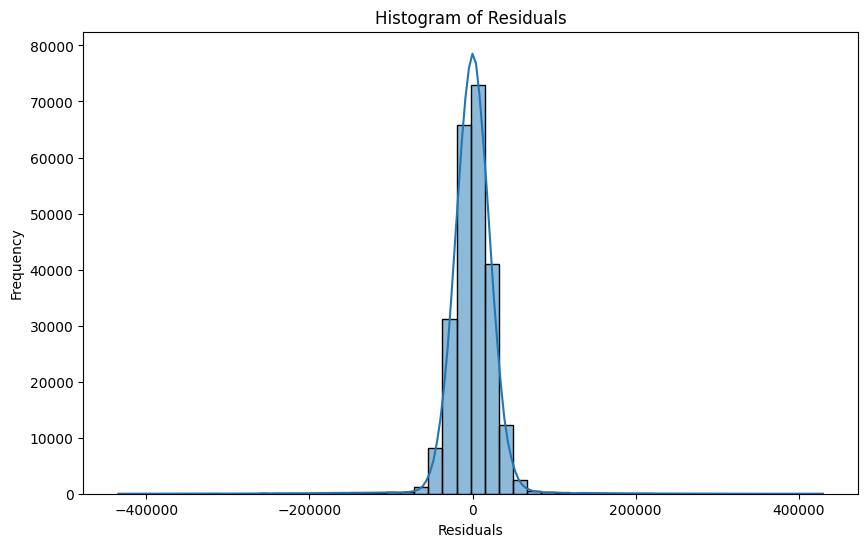

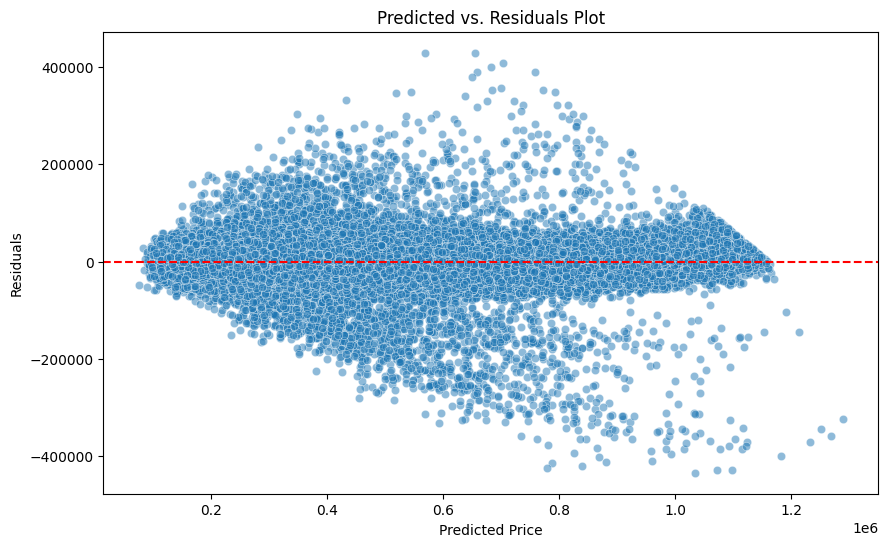

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from scipy.stats import zscore

# Load the trained model
model = joblib.load("stacking_model.pkl")
df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")
df = df.drop(columns=['Property ID']).dropna(subset=['Price'])
df['price_z'] = zscore(df['Price'])
df = df[df['price_z'].abs() <= 3].drop(columns=['price_z'])
X = df.drop(columns=['Price'])
y = df['Price']

y_pred = model.predict(X)
residuals = y - y_pred
analysis_df = df.copy()
analysis_df['Predicted_Price'] = y_pred
analysis_df['Residuals'] = residuals
# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Predicted Price': y_pred, 'Residuals': residuals})

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(plot_df['Residuals'], kde=True, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Scatter Plot of Predicted vs Residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted Price', y='Residuals', data=plot_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Predicted vs. Residuals Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.show()

In [41]:
analysis_df.head()

Location    Size  Bedrooms  Bathrooms  Year Built Condition           Type  \
0    CityA  3974.0       2.0        2.0      2007.0      Good  Single Family   
1    CityA  1660.0       2.0        3.0      1934.0      Good  Single Family   
2    CityC  2094.0       2.0        2.0      1950.0      Good  Single Family   
3    CityB  1930.0       2.0        3.0      1905.0      Good  Single Family   
5    CityB  3892.0       2.0        3.0      1904.0      Poor  Single Family   

   Date Sold     Price  Predicted_Price     Residuals  
0 2020-11-02  324000.0    300838.104744  23161.895256  
1 2022-10-23  795000.0    761488.926929  33511.073071  
2 2020-11-30  385000.0    398866.349634 -13866.349634  
3 2021-12-09  651000.0    695545.264358 -44545.264358  
5 2020-05-16  213000.0    172699.645110  40300.354890

In [42]:
analysis_df[analysis_df['Residuals'].abs()>30000]

Location    Size  Bedrooms  Bathrooms  Year Built Condition  \
1         CityA  1660.0       2.0        3.0      1934.0      Good   
3         CityB  1930.0       2.0        3.0      1905.0      Good   
5         CityB  3892.0       2.0        3.0      1904.0      Poor   
14        CityA  3719.0       5.0        2.0      1922.0      Poor   
26        CityB  1259.0       2.0        1.0      1924.0      Good   
...         ...     ...       ...        ...         ...       ...   
247129    CityA  1076.0       4.0        2.0      2010.0      Poor   
247136    CityB  3014.0       5.0        1.0      2017.0      Fair   
247156    CityB  2481.0       2.0        1.0      2016.0      Poor   
247160    CityD   908.0       1.0        3.0      1968.0      Good   
247170    CityA  2022.0       2.0        1.0      1952.0      Fair   

                 Type  Date Sold     Price  Predicted_Price     Residuals  
1       Single Family 2022-10-23  795000.0    761488.926929  33511.073071  
3       Single Family 2021-12-09  651000.0    695545.264358 -44545.264358  
5       Single Family 2020-05-16  213000.0    172699.645110  40300.354890  
14      Single Family 2021-03-18  220000.0    263837.343884 -43837.343884  
26      Single Family 2023-01-07  997000.0    951431.994421  45568.005579  
...               ...        ...       ...              ...           ...  
247129      Townhouse 2022-10-23  486000.0    450507.761222  35492.238778  
247136      Townhouse 2023-03-23  437000.0    472082.525489 -35082.525489  
247156      Townhouse 2020-06-17  209000.0    173441.328633  35558.671367  
247160      Townhouse 2024-10-27  642000.0    679423.712795 -37423.712795  
247170      Townhouse 2021-06-08  403000.0    368417.672632  34582.327368  

[39185 rows x 11 columns]

In [43]:
analysis_df[analysis_df['Residuals'].abs()>30000]['Type'].value_counts()

Type
Townhouse        15757
Single Family    13877
Condominium       9551
Name: count, dtype: int64

### Feature-wise Residual Analysis Visualizations

In [44]:
plot_df.head()

Predicted Price     Residuals
0    300838.104744  23161.895256
1    761488.926929  33511.073071
2    398866.349634 -13866.349634
3    695545.264358 -44545.264358
5    172699.645110  40300.354890

Visualizing residuals for categorical features:


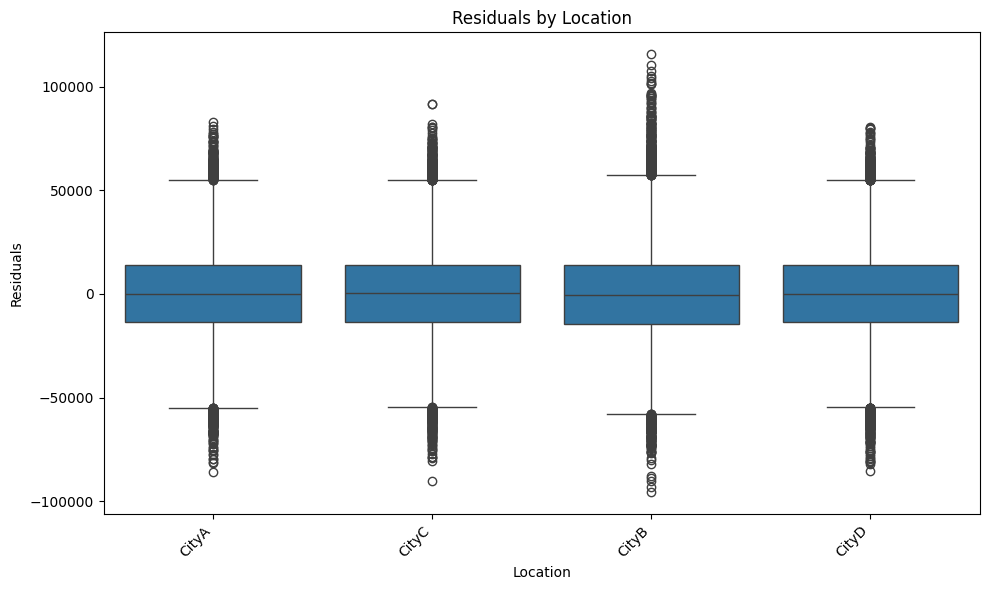

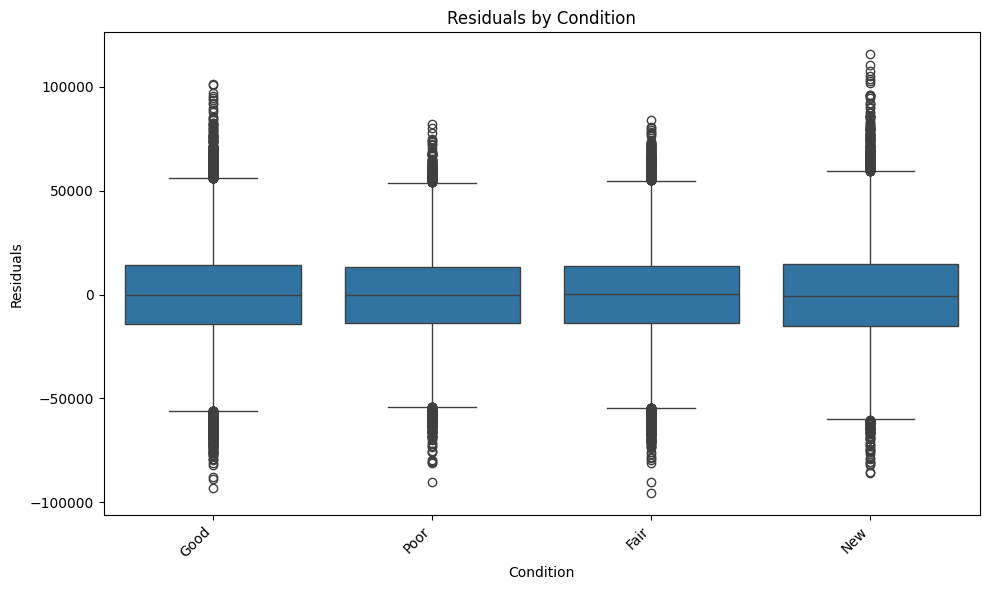

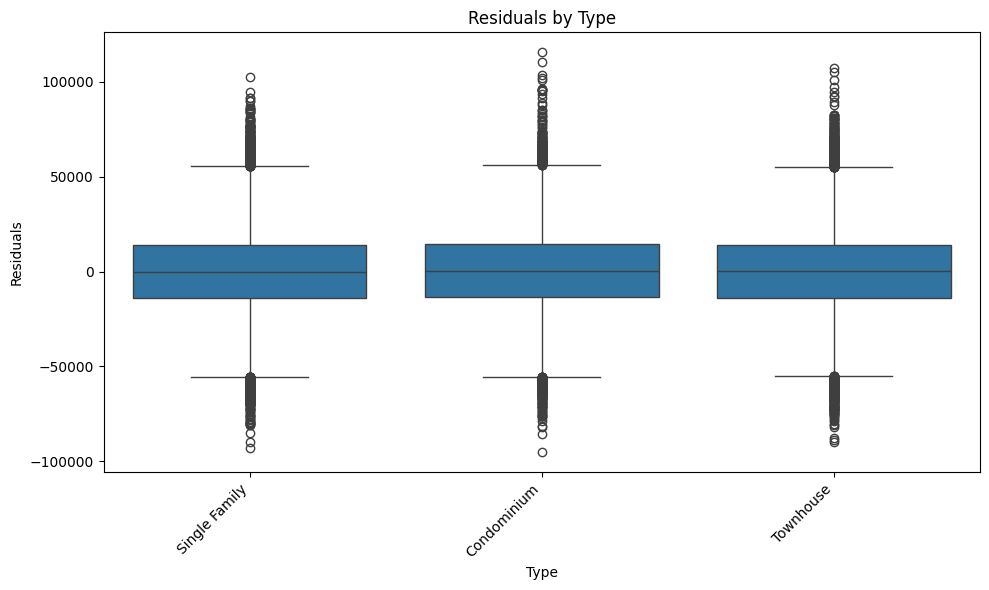

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical and numerical features based on the res_df DataFrame
cat_feats = ['Location', 'Condition', 'Type']
# Exclude 'residual' and the original categorical features from numeric features for plotting
numeric_feats_for_plotting = [col for col in res_df.columns if col not in cat_feats and col != 'residual']

# Visualize residuals for categorical features (Box plots)
print("Visualizing residuals for categorical features:")
for feat in cat_feats:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feat, y='residual', data=res_df)
    plt.title(f'Residuals by {feat}')
    plt.xlabel(feat)
    plt.ylabel('Residuals')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Visualizing residuals for numerical features:


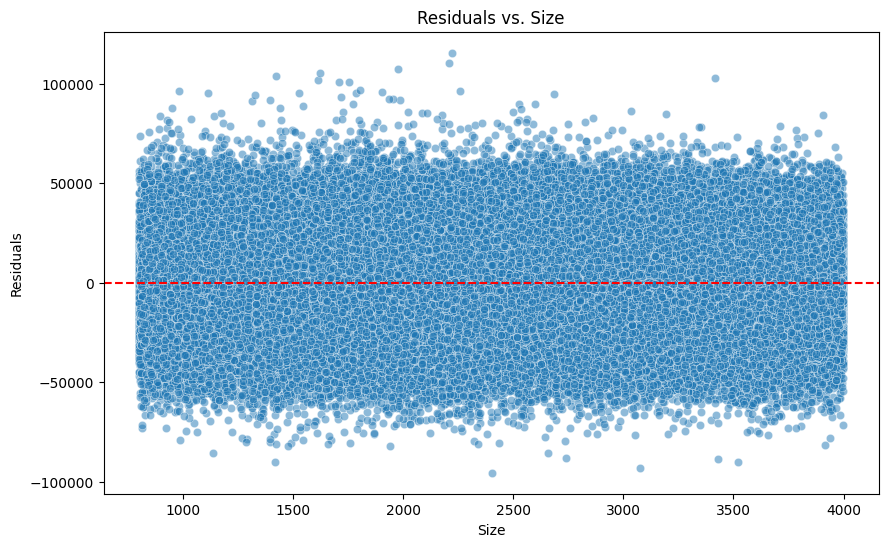

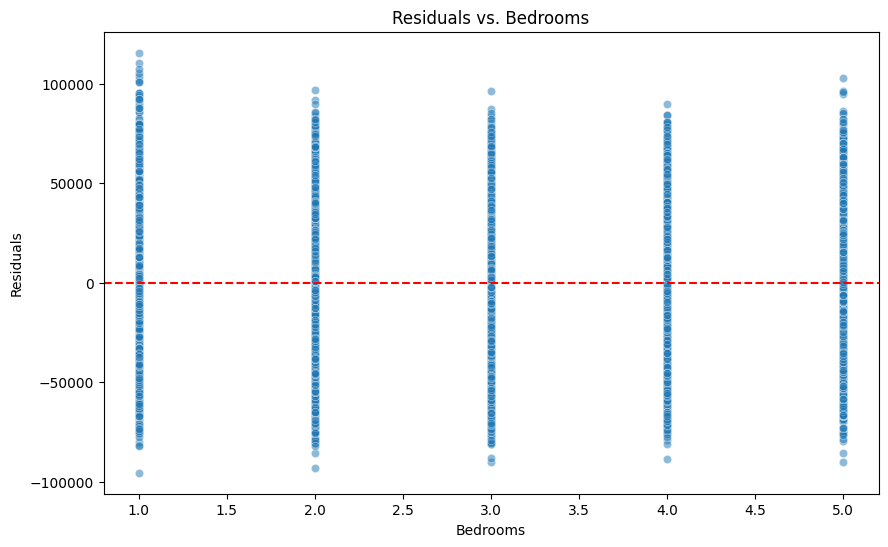

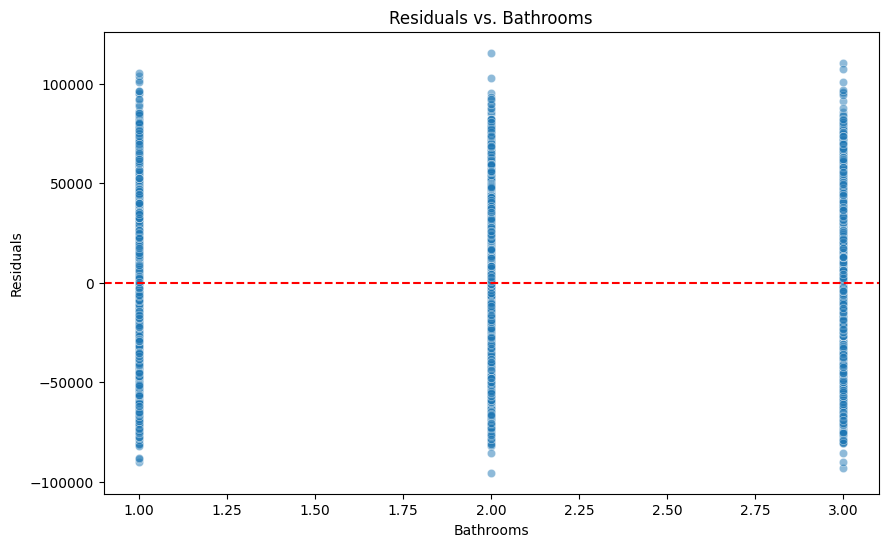

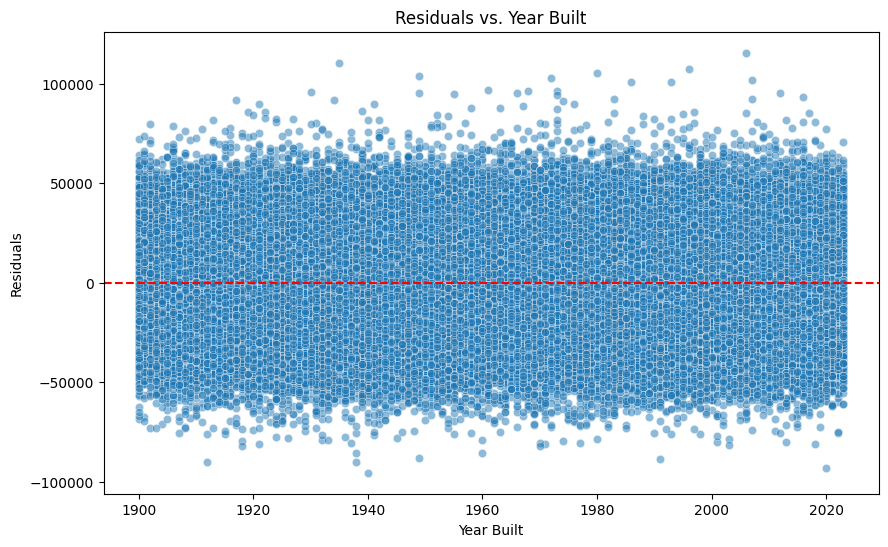

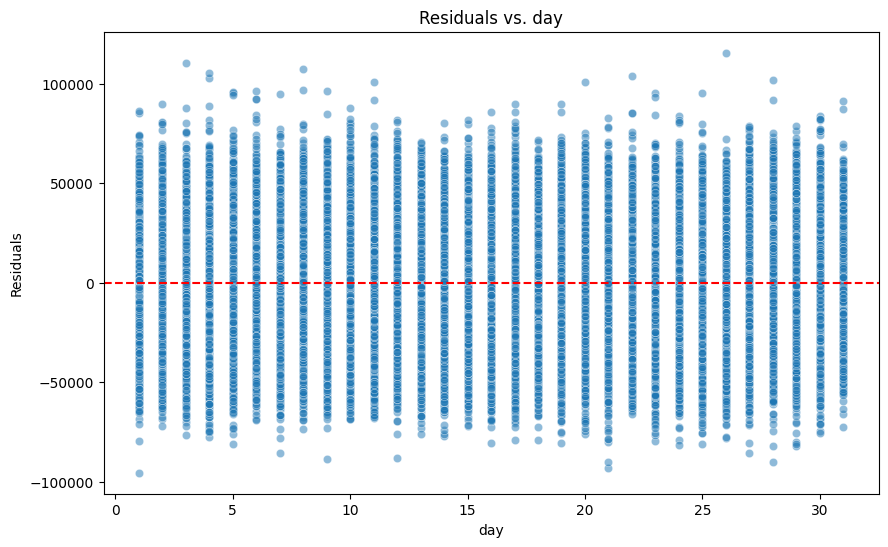

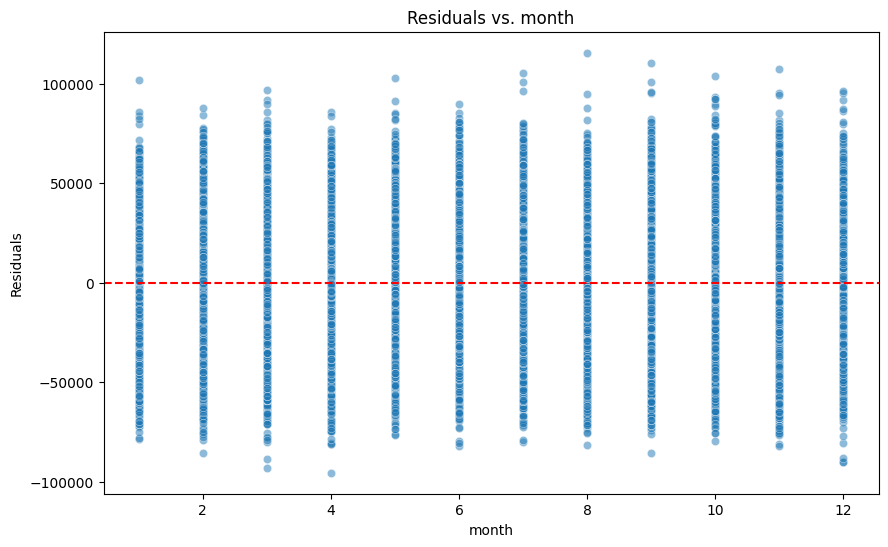

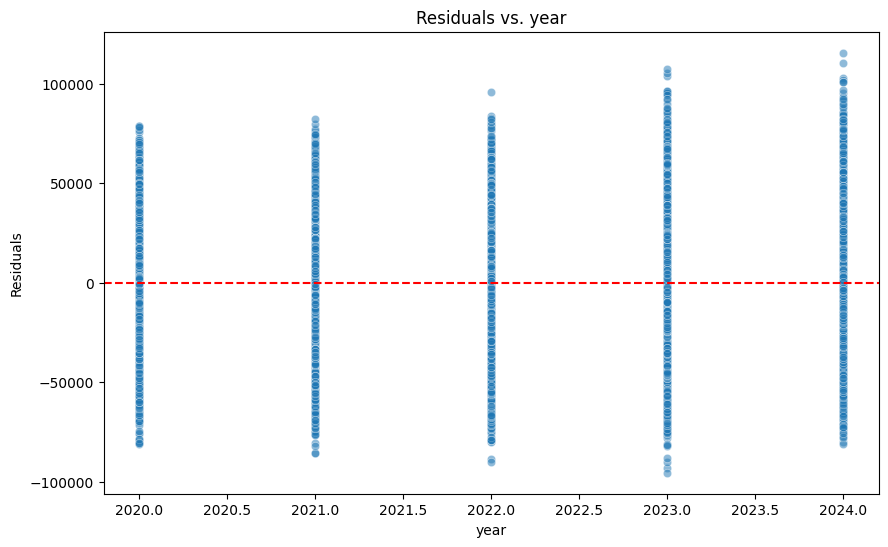

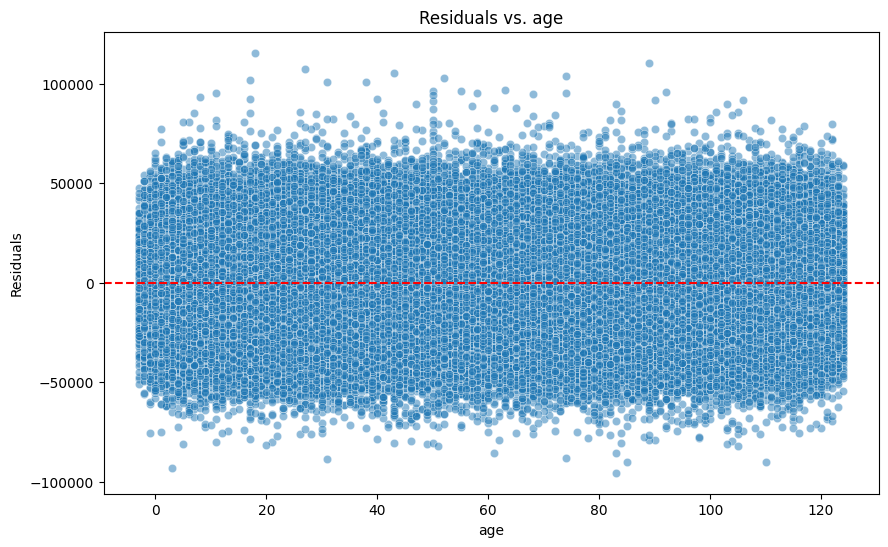

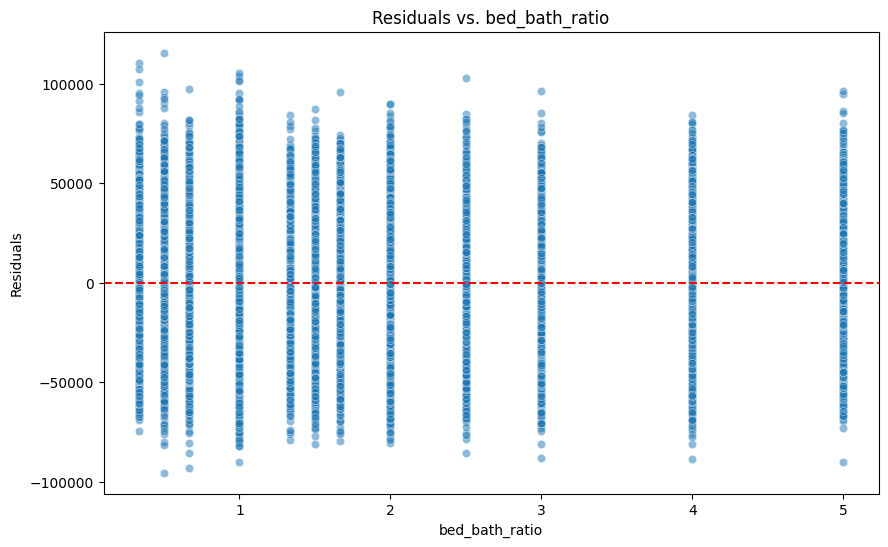

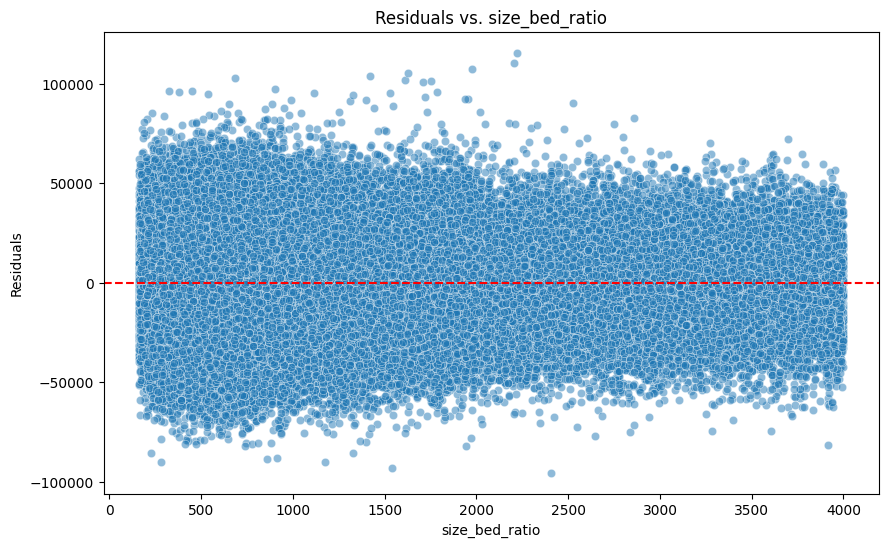

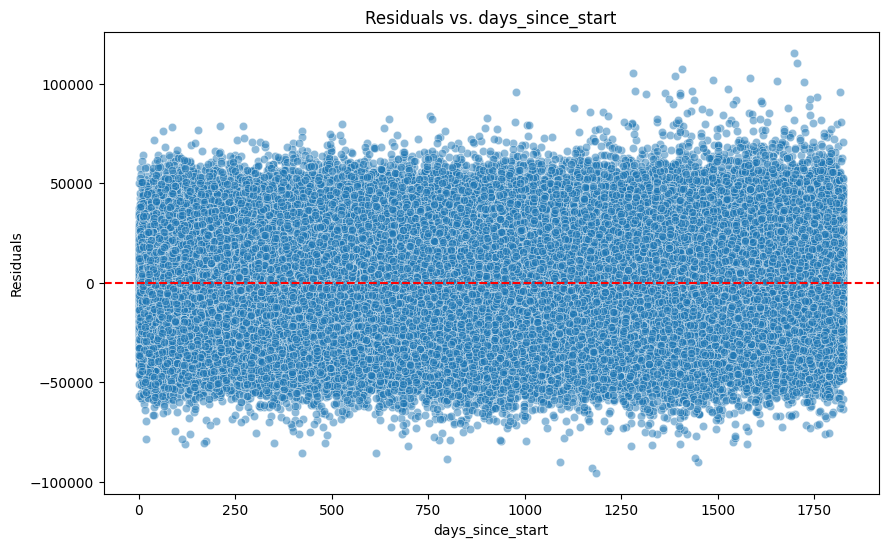

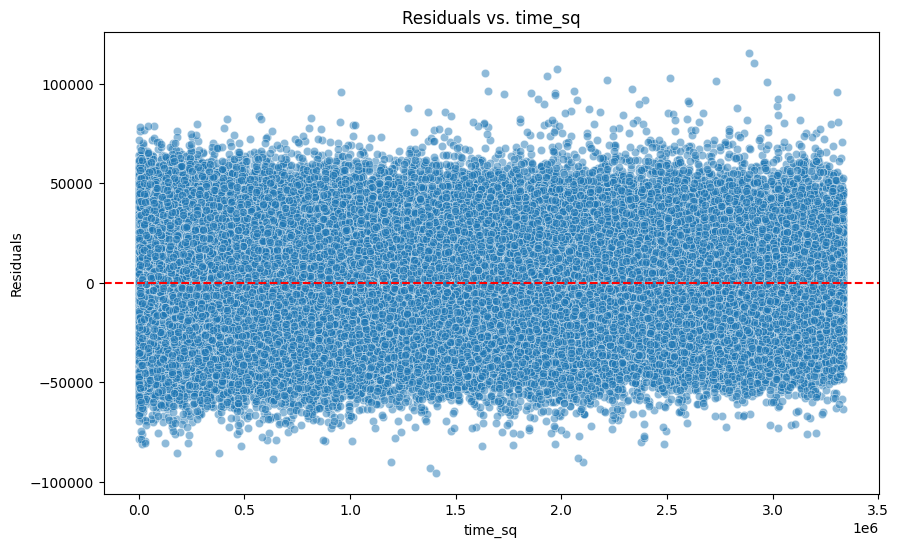

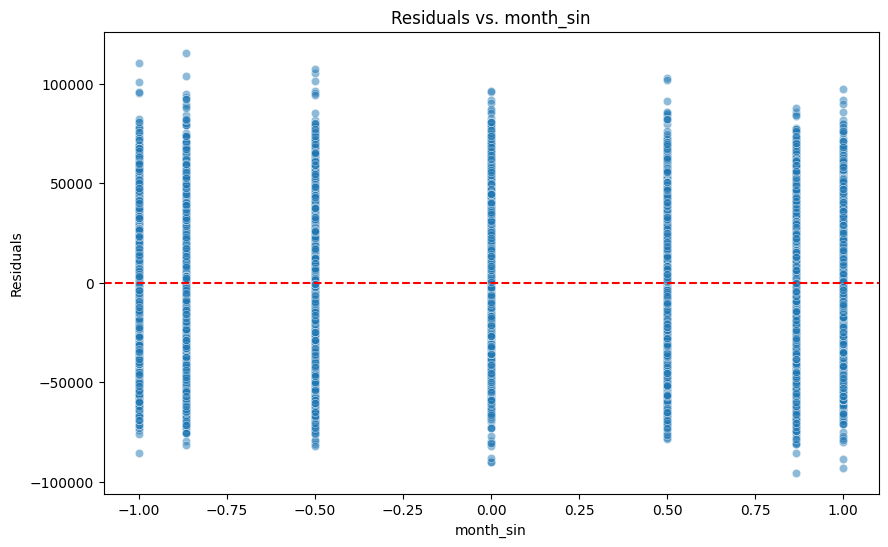

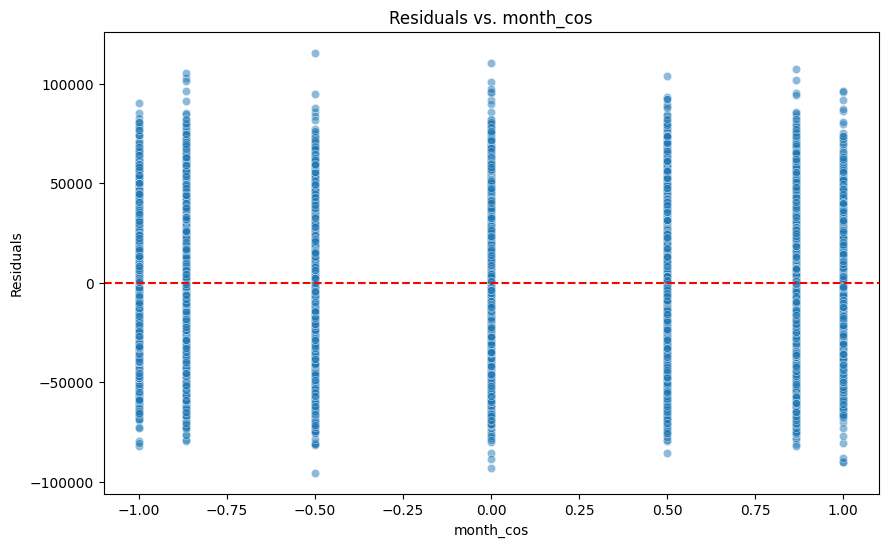

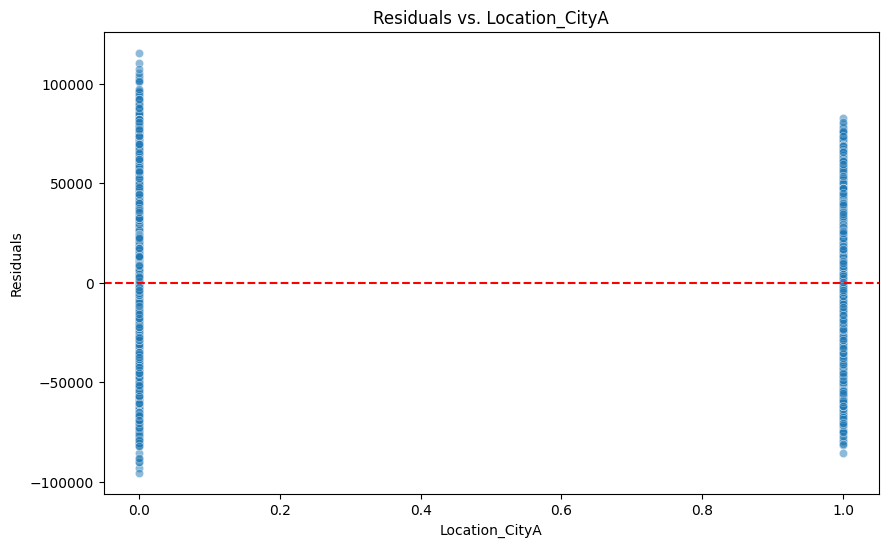

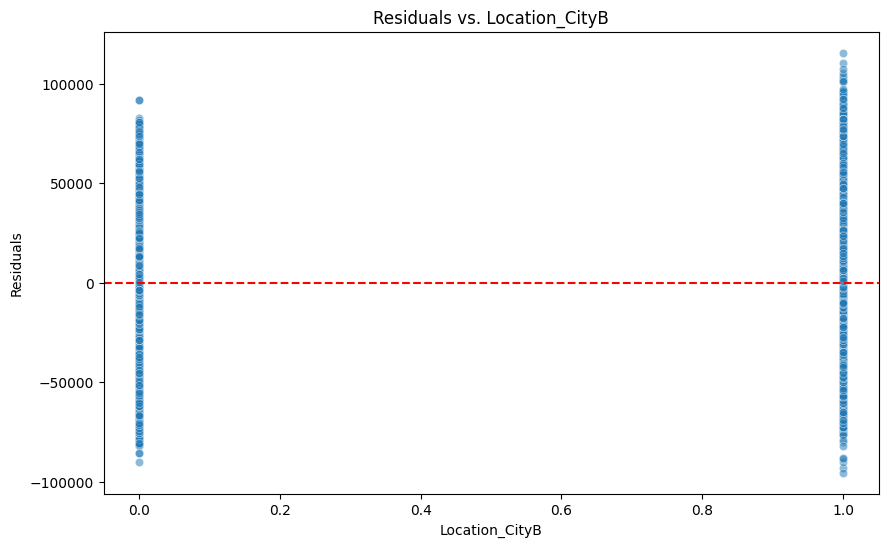

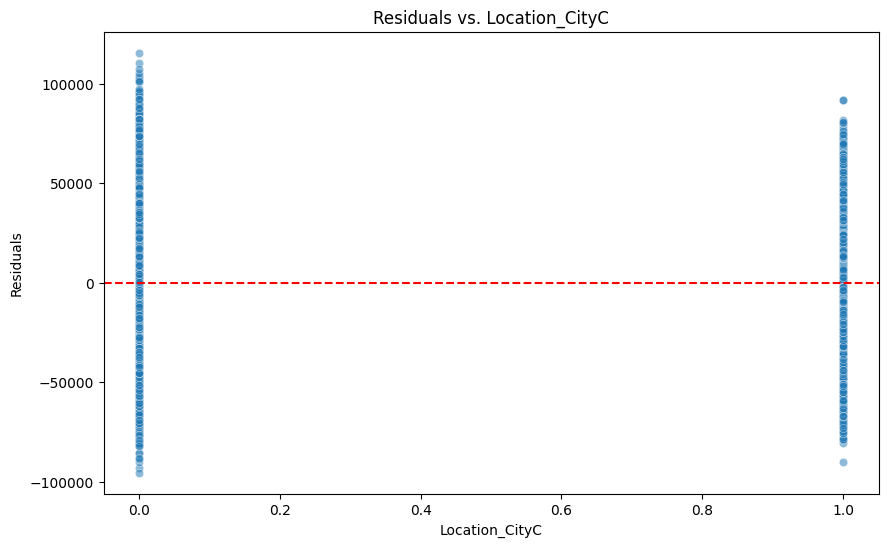

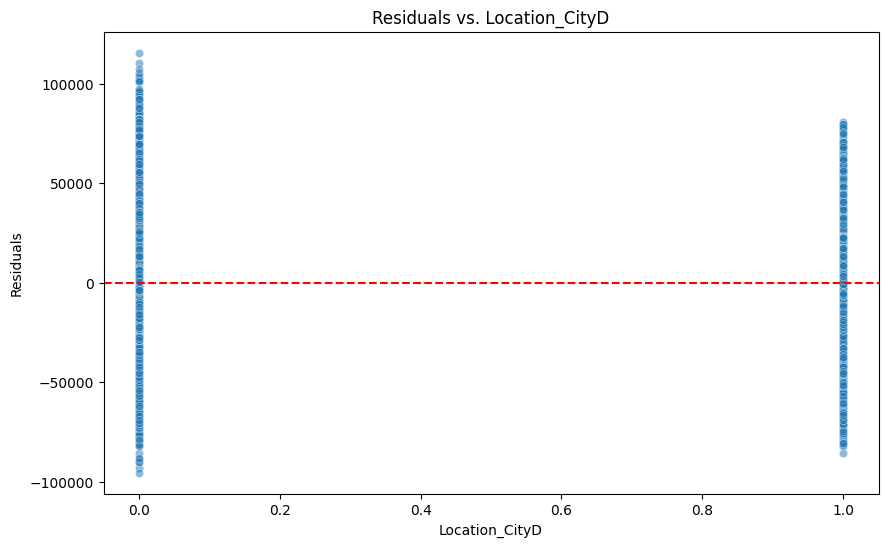

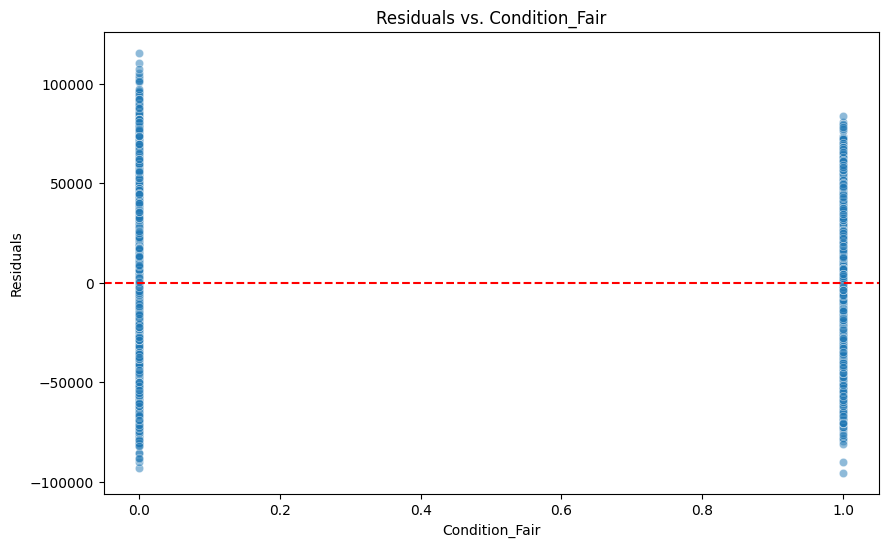

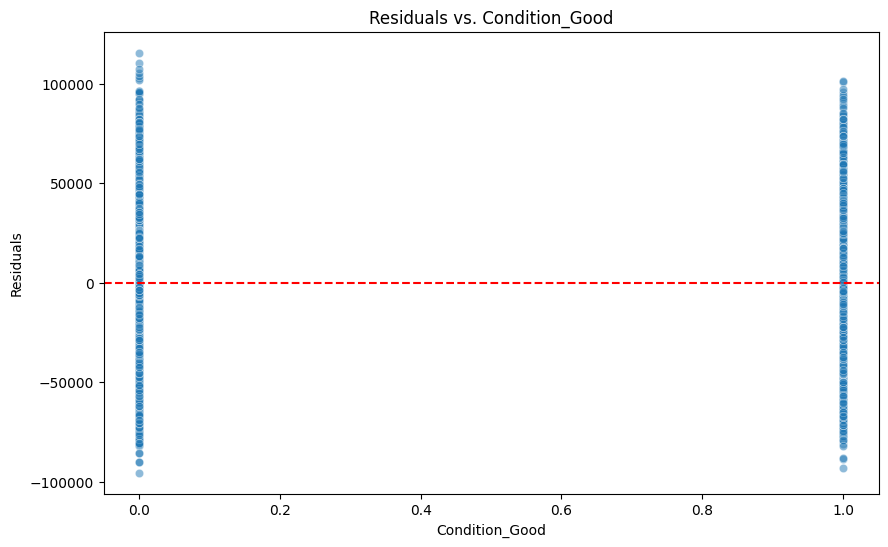

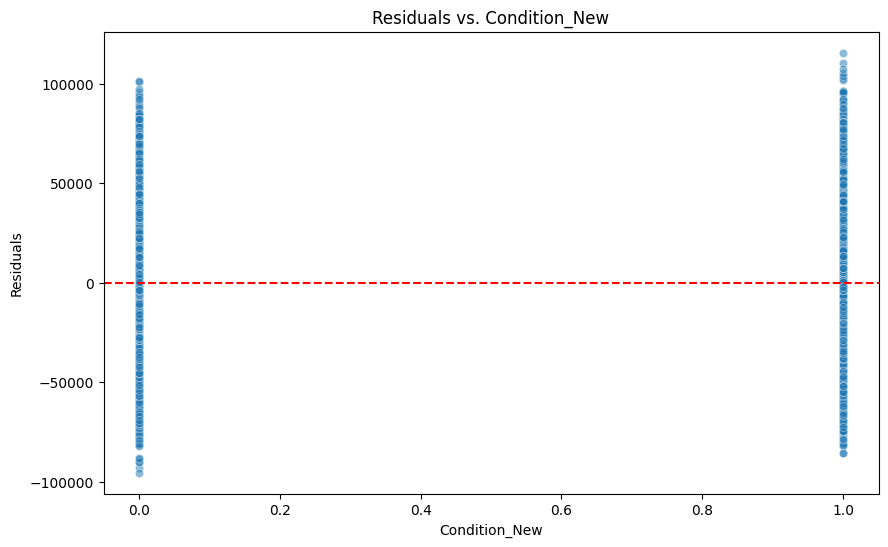

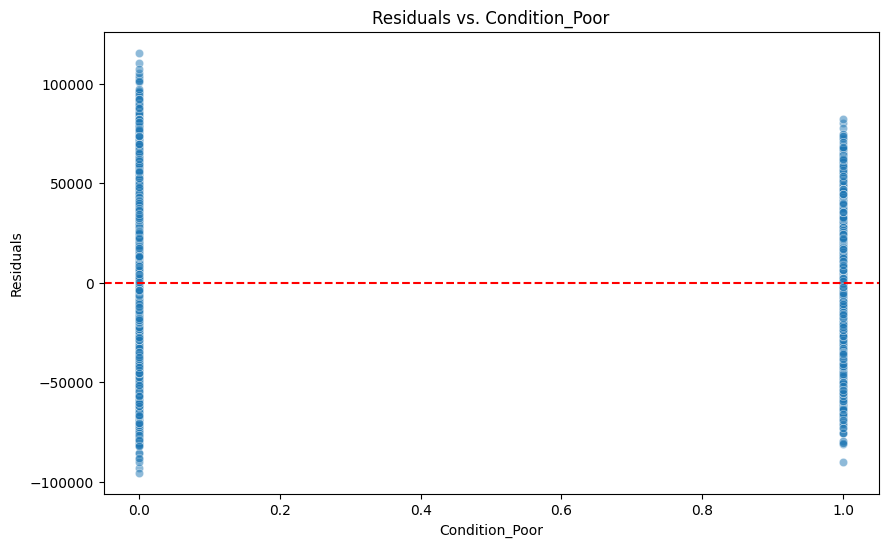

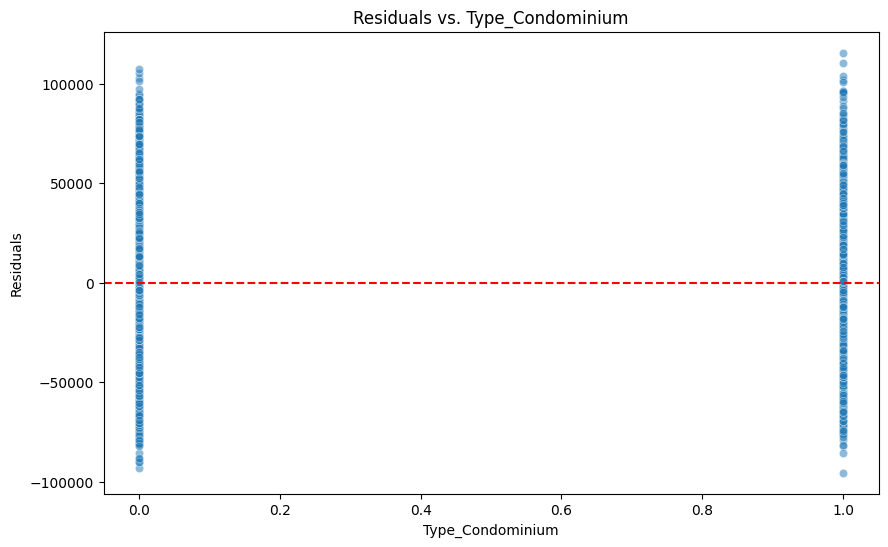

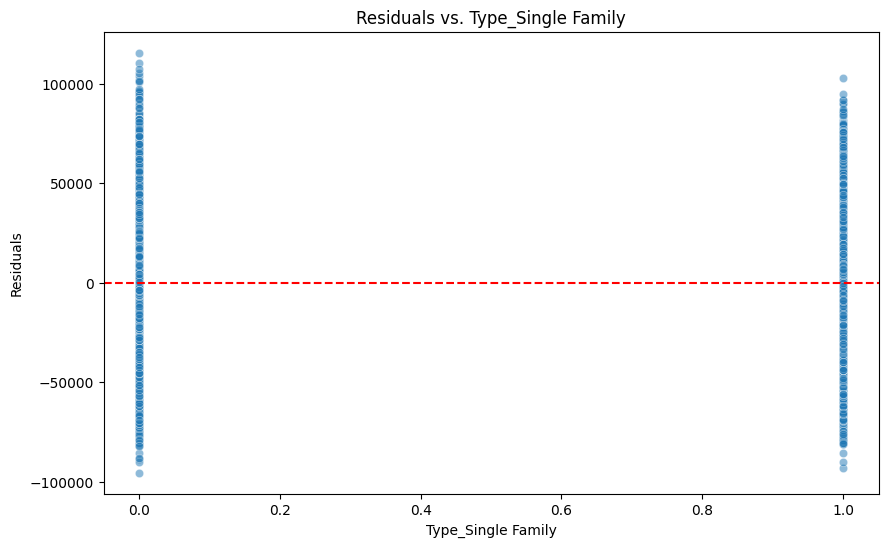

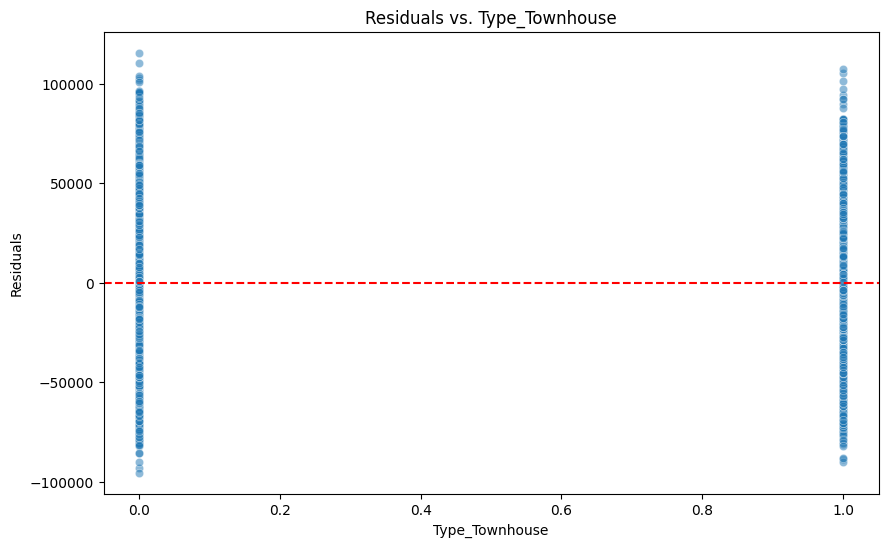

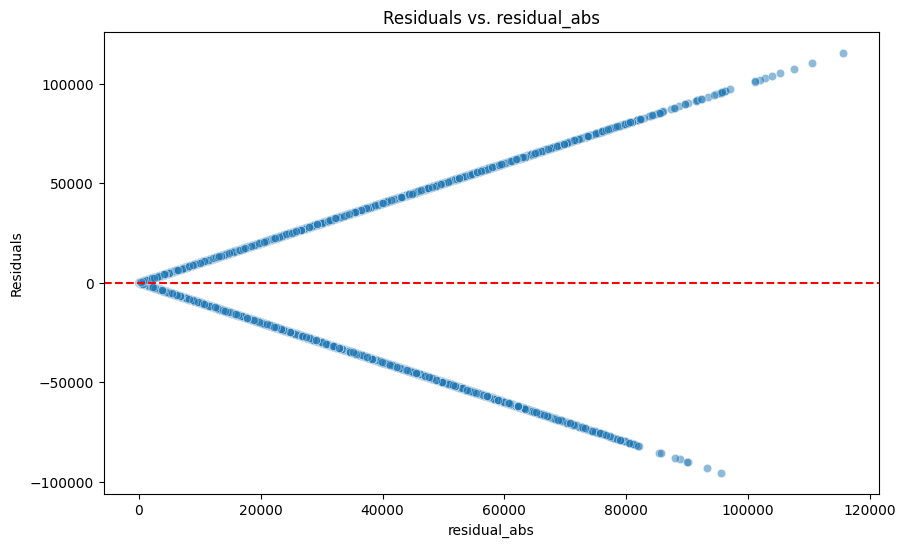

In [46]:
# Visualize residuals for numerical features (Scatter plots)
print("\nVisualizing residuals for numerical features:")
for feat in numeric_feats_for_plotting:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feat, y='residual', data=res_df, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. {feat}')
    plt.xlabel(feat)
    plt.ylabel('Residuals')
    plt.show()

In [4]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [7]:
# app_streamlit.py
%%writefile app_streamlit.py
import streamlit as st
import joblib
from datetime import datetime
import pandas as pd
import numpy as np
import cloudpickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_validate, KFold
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Feature transformer: date parsing + fixed ratio features
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        dates = pd.to_datetime(X['Date Sold'], dayfirst=True)
        X['day']            = dates.dt.day
        X['month']          = dates.dt.month
        X['year']           = dates.dt.year
        X['age']            = X['year'] - X['Year Built']
        X['bed_bath_ratio'] = X['Bedrooms'] / X['Bathrooms']
        X['size_bed_ratio'] = X['Size'] / X['Bedrooms']
        start = dates.min()
        X['days_since_start'] = (dates - start).dt.days
        X['time_sq']         = X['days_since_start'] ** 2
        X['month_sin']       = np.sin(2 * np.pi * X['month'] / 12)
        X['month_cos']       = np.cos(2 * np.pi * X['month'] / 12)
        return X.drop(columns=['Date Sold'])


@st.cache(allow_output_mutation=True)
def load_model():
    with open("stacking_model_cpkl.pkl", "rb") as f:
        return cloudpickle.load(f)

@st.cache
def load_data():
    # adjust path if needed
    df = pd.read_excel("/content/sample_data/Case Study 1 Data.xlsx")
    # drop unused cols
    df = df.drop(columns=["Property ID", "Price"]).dropna(subset=["Location"])
    return df

model = load_model()
df = load_data()

st.title("🏠 House Price Predictor")

st.sidebar.header("Input Features")

# Categorical inputs from training data
location = st.sidebar.selectbox("Location", df["Location"].unique())
condition = st.sidebar.selectbox("Condition", df["Condition"].unique())
ptype = st.sidebar.selectbox("Property Type", df["Type"].unique())

# Numeric inputs
size = st.sidebar.number_input("Size (sqft)", min_value=0.0, value=1000.0, step=50.0)
bedrooms = st.sidebar.number_input("Bedrooms", min_value=0, value=3, step=1)
bathrooms = st.sidebar.number_input("Bathrooms", min_value=0, value=2, step=1)
year_built = st.sidebar.number_input(
    "Year Built",
    min_value=1900,
    max_value=datetime.now().year,
    value=2010,
    step=1
)
date_sold = st.sidebar.date_input(
    "Date Sold",
    value=datetime.now()
)

# Assemble into a single‑row DataFrame
input_df = pd.DataFrame({
    "Location":      [location],
    "Size":          [size],
    "Bedrooms":      [bedrooms],
    "Bathrooms":     [bathrooms],
    "Year Built":    [year_built],
    "Condition":     [condition],
    "Type":          [ptype],
    "Date Sold":     pd.to_datetime([date_sold])
})

st.subheader("Feature Preview")
st.write(input_df)

# Predict button
if st.sidebar.button("Predict Price"):
    pred = model.predict(input_df)[0]
    st.subheader("🔮 Predicted Price")
    st.success(f"₹ {pred:,.0f}")
else:
    st.write("Adjust the inputs and click **Predict Price** in the sidebar.")


Writing app_streamlit.py
